In [ ]:
# inspired by https://arxiv.org/pdf/1907.02704.pdf and thu vu data analysis
# TODO: geneaological 

In [1]:
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from webdriver_manager.firefox import GeckoDriverManager

from selenium.webdriver.firefox.options import Options #to tweak options
from selenium.common.exceptions import NoSuchElementException #to raise error
from selenium.webdriver.common.by import By #to use find_element

import unidecode
import networkx as nx

print('package loaded')

website_choices = [{"name": "https://lotr.fandom.com/wiki/Category:", 
                   "url" : ["The_Hobbit_Characters", "The_Silmarillion_characters", "Characters_in_The_Children_of_H%C3%BArin"]},
                   {"name": "https://tolkiengateway.net/wiki/Category:", 
                    "url" : ["Characters_in_The_Hobbit", "Characters_in_The_Lord_of_the_Rings"]}
                  ]
choice = website_choices[1]
path = choice["url"][0]


package loaded


## Load Web Page 

In [3]:
# to disable GUI
firefox_options = Options()
firefox_profile = webdriver.FirefoxProfile()

firefox_options.add_argument("--headless") # Ensure GUI is off
#firefox_options.add_argument("--no-sandbox") # if i understand well, make it faster but less safe

# to disable image loading
firefox_profile = webdriver.FirefoxProfile()
firefox_profile.set_preference('permissions.default.image', 2)
firefox_profile.set_preference('dom.ipc.plugins.enabled.libflashplayer.so', 'false')

# to load the web browser
driver = webdriver.Firefox(executable_path=GeckoDriverManager().install(), options=firefox_options, firefox_profile=firefox_profile)
print('web loaded')

[WDM] - Downloading: 19.0kB [00:00, ?B/s]                                                                              
[WDM] - Downloading: 19.0kB [00:00, ?B/s]                                                                              
[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 1.58M/1.58M [00:00<00:00, 12.0MB/s]


web loaded


In [ ]:
# to quit the driver
driver.quit()
print('driver quited')

In [4]:
page_url = choice["name"] + path
driver.get(page_url)

# Accept cookies
# time.sleep(3)

try:
    driver.find_element(By.XPATH, '//div[text()="ACCEPTER"]').click()
except NoSuchElementException:
    print('no cookie button, or not in french')

no cookie button, or not in french


## Data mining lotr.fandom

In [ ]:
# Find the different characters in the hobbit with the first website
characters_listed_ref = driver.find_elements(by=By.CLASS_NAME, value="category-page__member-link")
characters_listed = [(i.text, i.get_attribute('href')) for i in characters_listed_ref]

In [ ]:
person_dict = {}
characters_list = []
iterator = 0
for person in characters_listed:
    person_dict = {} #assign to {} to change the pointer
    person_features = ["race", "gender"]
    person_url = person[1]
    person_name = person[0]

    person_dict['names'] = person_name
    person_dict['link'] = person_url
    # goes to the character webpage to mine the data
    driver.get(person_url)
    
    # find the element of wikipedia
    for feature in person_features:
        try:
            #get the div with data-source Race
            text = driver.find_element(By.XPATH, '//div[@data-source =\"' + feature + '"]/descendant::div').text 
            if feature == "othernames":
                person_dict['names'] += ", " + text
            else:
                person_dict[feature] = text
        except NoSuchElementException:
            person_dict[feature] = 'NaN'
            
    if not('Category' in person_dict['names']):
        characters_list.append(person_dict)
        
    progress = int(iterator/len(characters_listed) * 100)
    print(progress, " % progress")
    iterator += 1
characters_df = pd.DataFrame(characters_list)
print("100 % progress")

## Data mining tolkien gateway

In [5]:
characters_listed_ref = driver.find_elements(By.CSS_SELECTOR, 'div.mw-category-group > ul > li > a')
characters_listed = [(i.text, i.get_attribute('href')) for i in characters_listed_ref]


In [6]:
person_dict = {}
characters_list = []
iterator = 0

for person in characters_listed:
    person_dict = {} #assign to {} to change the pointer
    person_url, person_name = person[1], person[0]
    person_dict['names'], person_dict['link'] = person_name, person_url
    
    # goes to the character webpage to mine the data
    driver.get(person_url)
    
    # get the race of the person
    try:
        person_dict['race'] = driver.find_element(By.CSS_SELECTOR, "tr:nth-child(2) > td > a").text
    except NoSuchElementException:
        person_dict['race'] = None

    #get the other features that are wanted
    person_add_features = ["other names","gender", "birth", "death", "affiliation", "rule"]
    for feature in person_add_features:
        try:
            #get the right td, using the td before that contains feature's name
            text = driver.find_element(By.XPATH, "//td[contains(.,'" + feature.capitalize() + "')]/following-sibling::td").text
            person_dict[feature] = text
        except NoSuchElementException:
            person_dict[feature] = None
    if not('Category' in person_name):
        characters_list.append(person_dict)
    
    progress = int(iterator/len(characters_listed) * 100)
    print(progress, " % progress")
    iterator += 1

characters_df = pd.DataFrame(characters_list)
characters_df.to_json("data/mining/" + path +".json")

print("100 % progress")

0  % progress
2  % progress
4  % progress
7  % progress
9  % progress
12  % progress
14  % progress
17  % progress
19  % progress
21  % progress
24  % progress
26  % progress
29  % progress
31  % progress
34  % progress
36  % progress
39  % progress
41  % progress
43  % progress
46  % progress
48  % progress
51  % progress
53  % progress
56  % progress
58  % progress
60  % progress
63  % progress
65  % progress
68  % progress
70  % progress
73  % progress
75  % progress
78  % progress
80  % progress
82  % progress
85  % progress
87  % progress
90  % progress
92  % progress
95  % progress
97  % progress
100 % progress


In [78]:
characters_df.head(100)

,names,link,race,other names,gender,birth,death,affiliation,rule
0,Anborn,https://tolkiengateway.net/wiki/Anborn,Gondorian,None,Male,Late Third Age,None,None,None
1,Angbor,https://tolkiengateway.net/wiki/Angbor,Gondorian,"""the Fearless""",Male,Late Third Age,None,None,None
2,Aragorn,https://tolkiengateway.net/wiki/Aragorn,Arnorian,"Aragorn II, Elessar, Strider, Thorongil, The D...",Male,1 March T.A. 2931\nEriador,1 March Fo.A. 120[3] (aged 210)\nGondor,Fellowship of the Ring,T.A. 2933 - 3019 (Chieftain)\nT.A. 3019 - Fo.A...


## Data viz from data mining

In [2]:
characters_df = pd.read_json("data/mining/" + path +".json")
characters_df['race'] = characters_df['race'].apply(lambda x : 'Half-elves' if 'Half-elves' in str(x) else x)
characters_df['race'] = characters_df['race'].apply(lambda x : 'Ainur' if 'Ainur' in str(x) else x)
characters_df = characters_df.dropna(subset=['affiliation'])

print(characters_df.loc[characters_df["names"] == "Gandalf"]["affiliation"].values[0])
characters_df = characters_df.groupby("affiliation").filter(lambda x: len(x) > 1)

Heren Istarion (Wizards)
White Council
Thorin and Company
Fellowship of the Ring


In [198]:
characters_df = pd.read_json("data/mining/" + path +".json")
characters_df.loc[characters_df["names"] == "Mrs Maggot"]

,names,link,race,other names,gender,birth,death,affiliation,rule
102,Mrs Maggot,https://tolkiengateway.net/wiki/Mrs_Maggot,Hobbit,None,Female,None,None,None,None


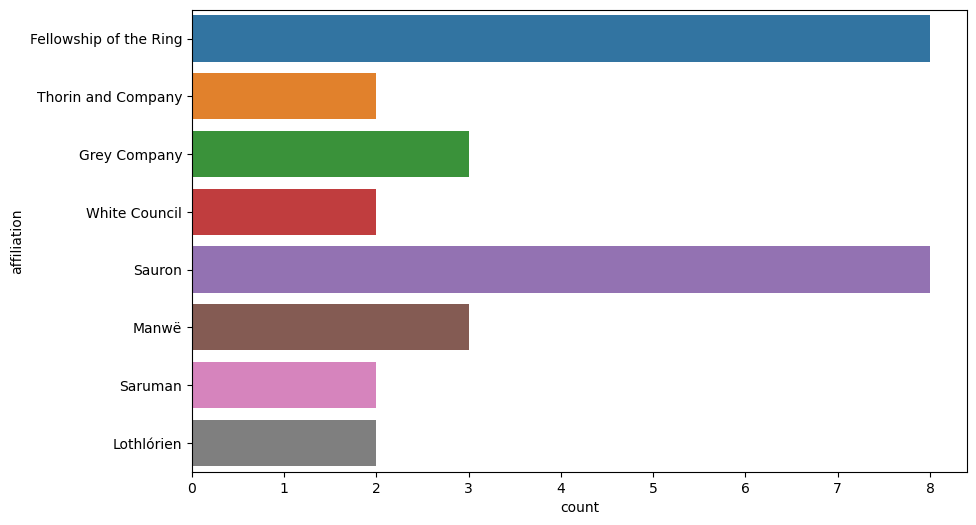

In [171]:
plt.figure(figsize=(10,6))
sns.countplot(y = characters_df['affiliation'] )
plt.show()


In [3]:
characters_df.loc[characters_df['race'] == 'Men' & characters_df['gender'] == 'Female']

TypeError: Cannot perform 'rand_' with a dtyped [object] array and scalar of type [bool]